In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
df_train = pd.read_pickle('../input/processed_data.pickle')
df_train.dropna(subset=['shot_made_flag'], inplace=True)
df_train.dropna(subset=['MA200'], inplace=True)
df_train.shape

(25538, 195)

## Feature selection
We will use the xgboost feature importance scores to select our features

In [5]:
# we select all the features
all_features = df_train.drop(['shot_id','game_date','shot_made_flag'],axis=1).columns
model = XGBClassifier()
model.fit(df_train[all_features], df_train['shot_made_flag'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

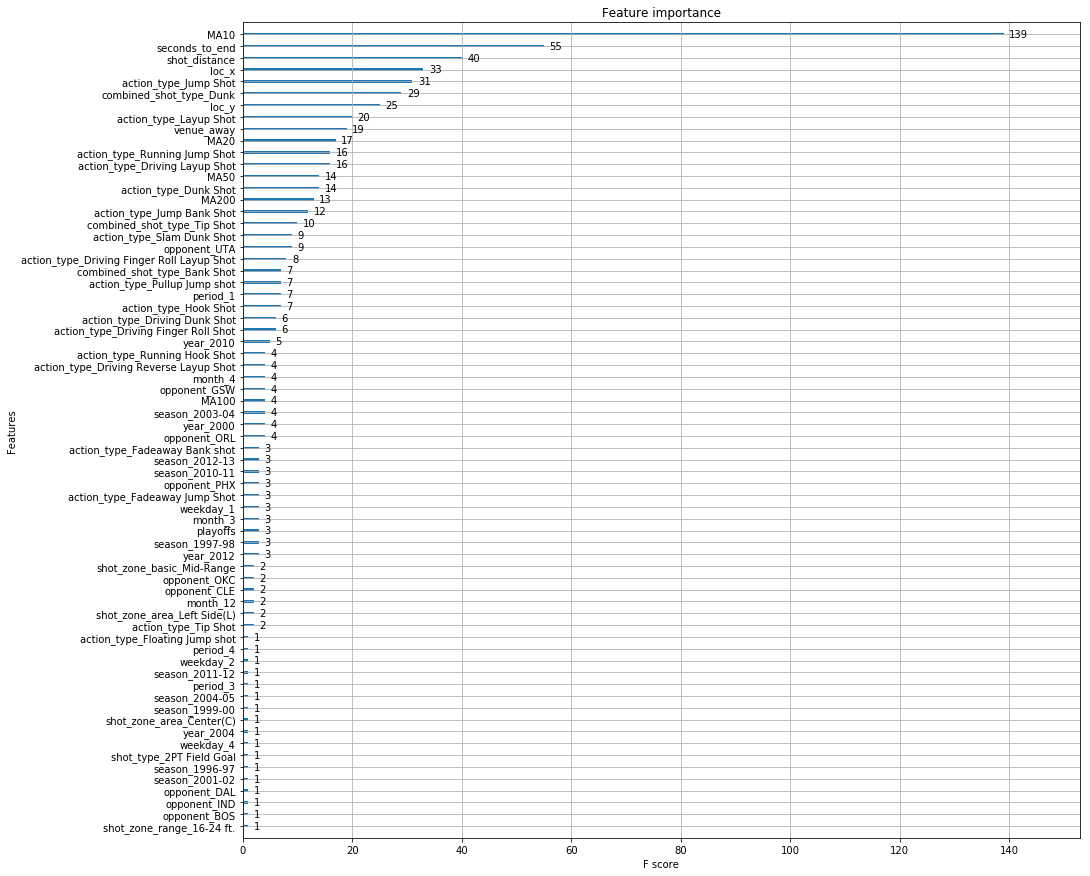

In [4]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(15,15)

In [6]:
# find the best threshold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

X = df_train[all_features]
y = df_train['shot_made_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)

score = metrics.log_loss(y_test, y_pred)

print('score: %.2f' % score)

features_scores = model.feature_importances_ 
thresholds = np.sort(features_scores)

ti=-1
best_t = 0
best_score = 1
for t in thresholds:
    if t != ti:
        ti = t
        # select features using threshold
        selection = SelectFromModel(model, threshold=t, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier()
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)
        score = metrics.log_loss(y_test, y_pred)
        print('Thresh=%.3f, n=%d, score: %2f' % (t, select_X_train.shape[1], score))
        
        # save best threshold
        if score < best_score:
            best_t = t
            best_score = score

print('Best thresh=%.3f, best score: %2f' % (best_t, best_score))


score: 0.56
Thresh=0.000, n=192, score: 0.558394
Thresh=0.002, n=65, score: 0.558394
Thresh=0.003, n=49, score: 0.557837
Thresh=0.005, n=38, score: 0.557497
Thresh=0.006, n=31, score: 0.557910
Thresh=0.008, n=28, score: 0.558649
Thresh=0.009, n=24, score: 0.559164
Thresh=0.011, n=22, score: 0.558897
Thresh=0.012, n=21, score: 0.559517
Thresh=0.015, n=19, score: 0.558974
Thresh=0.017, n=17, score: 0.560019
Thresh=0.018, n=16, score: 0.559500
Thresh=0.020, n=14, score: 0.562025
Thresh=0.023, n=13, score: 0.562026
Thresh=0.028, n=12, score: 0.563483
Thresh=0.029, n=10, score: 0.562811
Thresh=0.034, n=9, score: 0.572619
Thresh=0.045, n=7, score: 0.572256
Thresh=0.048, n=6, score: 0.573204
Thresh=0.049, n=5, score: 0.581577
Thresh=0.052, n=4, score: 0.608122
Thresh=0.055, n=3, score: 0.612717
Thresh=0.074, n=2, score: 0.626576
Thresh=0.204, n=1, score: 0.628974
Best thresh=0.005, best score: 0.557497


In [7]:
# create a mask we'll use later for selecting features
mask = features_scores
mask[mask > best_t] = True
mask[mask <= best_t] = False
mask = mask.astype(bool)
mask

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False,  True,  True,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [7]:
# make arrays with data
X = np.array(df_train[all_features])
# reduce X using mask
X_select = X[:,mask]

y = np.array(df_train['shot_made_flag'])

In [8]:
# save arrays to files
np.savetxt('../input/X.txt',X, delimiter=',')
np.savetxt('../input/X_select.txt', X_select,  delimiter=',')
np.savetxt('../input/y.txt', y, delimiter=',')

## Parameters tuning

In [9]:
def modelfit(model, features, label, scoring):
    ''' makes an evaluation of a model's performance
    parameters
    ----------
        model 
            the model to evaluate
        features    array
            features
        label    array
            labels
        scoring    string
            the scoring method
    return
    -------
    '''
    
    # fit the model
    model.fit(features, label)
    
    
    # predict the training set
    y_predictions = model.predict(features)
    y_proba = model.predict_proba(features)[:,1]
    
    # perform cross-validation
    n_fold = 10
    seed = 7
    kfold = KFold(n_splits=n_fold, random_state=seed)
    cv_score = cross_val_score(model, features, label, cv = kfold, scoring=scoring) 
    
    print('\nModel Report')
    print('Model:\n', model)
    print('\nCV score (%s): \nMean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g \n' % (scoring,np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    print('\nAUC score: %f' % metrics.roc_auc_score(y, y_proba ))
    fig = plt.figure()
    fig.suptitle('Cross Validation Score')
    ax = fig.add_subplot(111)
    plt.boxplot(cv_score)
    plt.show()


Model Report
Model:
 XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

CV score (neg_log_loss): 
Mean - -0.5542155 | Std - 0.008948435 | Min - -0.5708865 | Max - -0.5369769 


AUC score: 0.787731


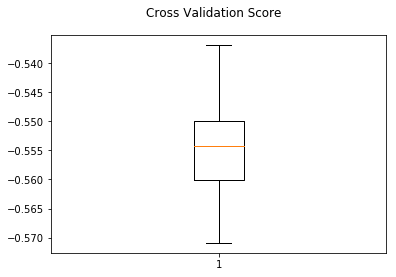

In [10]:
# Get baseline performance
xgb_base = XGBClassifier()
modelfit(xgb_base, X_select, y, 'neg_log_loss' )

In [9]:
# we fix the learning rate and number of estimators
max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8 
colsample_bytree = 0.8
scale_pos_weight = 1

In [12]:
def tune_model(model, features, label, params, scoring='accuracy', verbose=0, jobs=2,):
    ''' run a GridSearchCV optimization on a mode
    parameters
    ----------
        model
            the model to be optimized
        features    array
        
        label    array
        
        params    dictionary
            the parameters to be tested
    return
    --------
        better_model
            a model with optimized parameters
    
    '''
    
    gsearch = GridSearchCV(estimator = model,
                           param_grid = params,
                           scoring = scoring,
                           n_jobs=jobs,
                           iid=False,
                           cv=10, 
                           verbose = verbose)
    
    gsearch.fit(features, label)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    return gsearch.best_estimator_

## Tuning tree based parameters

In [18]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

xgb1 = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = colsample_bytree,
    gamma = gamma, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = max_depth,
    min_child_weight = min_child_weight, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0, 
    reg_lambda = 1,
    scale_pos_weight = scale_pos_weight, 
    seed = 0, 
    silent = True, 
    subsample = subsample)

best_model = tune_model(xgb1, X_select, y, param_test1, 'neg_log_loss',2)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   4.6s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   4.8s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   5.3s
[CV] .................. max_depth=3, min_child_weight=1, total=   5.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   5.1s
[CV] max_depth

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   52.2s


[CV] .................. max_depth=5, min_child_weight=1, total=   8.9s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   7.7s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   7.3s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   7.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   6.9s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   7.4s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   7.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  5.3min finished


{'max_depth': 3, 'min_child_weight': 3}
-0.554253020796


In [21]:
# we fix min_child_weight at 3
min_child_weight = 3

# max_depth is at the minimum. We try with lower values
param_test2 = {
    'max_depth':range(1,4,1)
}

xgb2 = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = colsample_bytree,
    gamma = gamma, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = max_depth,
    min_child_weight = min_child_weight, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0, 
    reg_lambda = 1,
    scale_pos_weight = scale_pos_weight, 
    seed = 0, 
    silent = True, 
    subsample = subsample)

best_model = tune_model(xgb2, X_select, y, param_test1, 'neg_log_loss',2)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   1.7s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   1.7s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   2.8s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   3.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   3.6s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   3.9s
[CV] max_depth

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.0min


[CV] .................. max_depth=5, min_child_weight=1, total=   7.0s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.6s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   4.8s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   4.0s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   4.0s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   4.9s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   4.5s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  6.3min finished


{'max_depth': 3, 'min_child_weight': 3}
-0.554253020796


In [ ]:
# we fix max_depth at 3
max_depth = 3

In [12]:
# tune gamma
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

xgb3 = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = colsample_bytree,
    gamma = gamma, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0, 
    reg_lambda = 1,
    scale_pos_weight = scale_pos_weight, 
    seed = 0, 
    silent = True, 
    subsample = subsample)

best_model = tune_model(xgb3, X_select, y, param_test3, 'neg_log_loss',2)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   1.7s
[CV] ........................................ gamma=0.0, total=   1.7s
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.4s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.7s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.6s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.8s
[CV] gamma=0.0 .

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   47.9s


[CV] ........................................ gamma=0.3, total=   2.6s
[CV] gamma=0.3 .......................................................
[CV] ........................................ gamma=0.3, total=   2.5s
[CV] gamma=0.4 .......................................................
[CV] ........................................ gamma=0.3, total=   2.3s
[CV] gamma=0.4 .......................................................
[CV] ........................................ gamma=0.4, total=   2.1s
[CV] gamma=0.4 .......................................................
[CV] ........................................ gamma=0.4, total=   2.5s
[CV] gamma=0.4 .......................................................
[CV] ........................................ gamma=0.4, total=   2.3s
[CV] gamma=0.4 .......................................................
[CV] ........................................ gamma=0.4, total=   2.2s
[CV] gamma=0.4 .......................................................
[CV] .

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.0min finished


{'gamma': 0.4}
-0.554186967205


In [14]:
# tune subsample and colsample_bytree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb4 = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = colsample_bytree,
    gamma = 0.4, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0, 
    reg_lambda = 1,
    scale_pos_weight = scale_pos_weight, 
    seed = 0, 
    silent = True, 
    subsample = subsample)

best_model = tune_model(xgb4, X_select, y, param_test4, 'neg_log_loss',2)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   2.1s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   2.1s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.7s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.7s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   2.5s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   2.6s
[CV] colsample

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   42.2s


[CV] .............. colsample_bytree=0.6, subsample=0.9, total=   2.1s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.9, total=   2.3s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.9, total=   2.3s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.6, total=   2.1s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.6, total=   2.0s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] .

[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:  3.4min finished


{'colsample_bytree': 0.9, 'subsample': 0.9}
-0.554035603662


In [17]:
# both parameters are at the maximum.
# I try higher values
param_test4b = {
    'subsample':[i/100.0 for i in range(90,96)],
    'colsample_bytree':[i/100.0 for i in range(90,96)]
}

xgb4b = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = colsample_bytree,
    gamma = 0.4, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0, 
    reg_lambda = 1,
    scale_pos_weight = scale_pos_weight, 
    seed = 0, 
    silent = True, 
    subsample = subsample)

best_model = tune_model(xgb4b, X_select, y, param_test4b, 'neg_log_loss',2)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.9, total=   2.2s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.9, total=   2.2s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.9, total=   2.7s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.9, total=   2.8s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.9, total=   1.8s
[CV] colsample_bytree=0.9, subsample=0.9 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.9, total=   1.8s
[CV] colsample

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   48.8s


[CV] ............. colsample_bytree=0.9, subsample=0.93, total=   2.3s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] ............. colsample_bytree=0.9, subsample=0.93, total=   2.2s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] ............. colsample_bytree=0.9, subsample=0.94, total=   2.1s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] ............. colsample_bytree=0.9, subsample=0.94, total=   2.1s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] ............. colsample_bytree=0.9, subsample=0.94, total=   2.1s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] ............. colsample_bytree=0.9, subsample=0.94, total=   2.1s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] ............. colsample_bytree=0.9, subsample=0.94, total=   2.1s
[CV] colsample_bytree=0.9, subsample=0.94 ............................
[CV] .

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  3.6min


[CV] ............ colsample_bytree=0.92, subsample=0.93, total=   2.6s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] ............ colsample_bytree=0.92, subsample=0.93, total=   2.7s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] ............ colsample_bytree=0.92, subsample=0.94, total=   2.3s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] ............ colsample_bytree=0.92, subsample=0.94, total=   2.3s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] ............ colsample_bytree=0.92, subsample=0.94, total=   2.3s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] ............ colsample_bytree=0.92, subsample=0.94, total=   2.3s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] ............ colsample_bytree=0.92, subsample=0.94, total=   2.4s
[CV] colsample_bytree=0.92, subsample=0.94 ...........................
[CV] .

[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:  8.2min finished


{'colsample_bytree': 0.9, 'subsample': 0.9}
-0.554035603662


In [13]:
# tuning regularization parameters
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb5 = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = 0.9,
    gamma = 0.4, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_lambda = 1,
    scale_pos_weight = 1, 
    seed = 0, 
    silent = True, 
    subsample = 0.9)

best_model = tune_model(xgb5, X_select, y, param_test5, 'neg_log_loss',2)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   2.1s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   2.2s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   2.5s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   2.6s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   2.9s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   3.0s
[CV] reg_alpha=1

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   58.8s


[CV] reg_alpha=1 .....................................................
[CV] ...................................... reg_alpha=1, total=   2.3s
[CV] reg_alpha=100 ...................................................
[CV] ...................................... reg_alpha=1, total=   2.3s
[CV] reg_alpha=100 ...................................................
[CV] .................................... reg_alpha=100, total=   2.3s
[CV] reg_alpha=100 ...................................................
[CV] .................................... reg_alpha=100, total=   2.3s
[CV] reg_alpha=100 ...................................................
[CV] .................................... reg_alpha=100, total=   2.3s
[CV] reg_alpha=100 ...................................................
[CV] .................................... reg_alpha=100, total=   2.5s
[CV] reg_alpha=100 ...................................................
[CV] .................................... reg_alpha=100, total=   2.5s
[CV] r

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.3min finished


{'reg_alpha': 0.01}
-0.553964612854


In [15]:
# fine tune reg_alpha
param_test5b = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgb5b = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = 0.9,
    gamma = 0.4, 
    learning_rate = 0.1, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_lambda = 1,
    scale_pos_weight = 1, 
    seed = 0, 
    silent = True, 
    subsample = 0.9)

best_model = tune_model(xgb5b, X_select, y, param_test5b, 'neg_log_loss',2)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] reg_alpha=0 .....................................................
[CV] reg_alpha=0 .....................................................
[CV] ...................................... reg_alpha=0, total=   1.8s
[CV] reg_alpha=0 .....................................................
[CV] ...................................... reg_alpha=0, total=   1.8s
[CV] reg_alpha=0 .....................................................
[CV] ...................................... reg_alpha=0, total=   3.5s
[CV] reg_alpha=0 .....................................................
[CV] ...................................... reg_alpha=0, total=   3.7s
[CV] reg_alpha=0 .....................................................
[CV] ...................................... reg_alpha=0, total=   2.4s
[CV] reg_alpha=0 .....................................................
[CV] ...................................... reg_alpha=0, total=   2.7s
[CV] reg_alpha=0

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.0min


[CV] ................................... reg_alpha=0.01, total=   3.6s
[CV] reg_alpha=0.01 ..................................................
[CV] ................................... reg_alpha=0.01, total=   3.1s
[CV] reg_alpha=0.05 ..................................................
[CV] ................................... reg_alpha=0.01, total=   2.8s
[CV] reg_alpha=0.05 ..................................................
[CV] ................................... reg_alpha=0.05, total=   3.0s
[CV] reg_alpha=0.05 ..................................................
[CV] ................................... reg_alpha=0.05, total=   3.8s
[CV] reg_alpha=0.05 ..................................................
[CV] ................................... reg_alpha=0.05, total=   2.8s
[CV] reg_alpha=0.05 ..................................................
[CV] ................................... reg_alpha=0.05, total=   2.7s
[CV] reg_alpha=0.05 ..................................................
[CV] .

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.3min finished


{'reg_alpha': 0.01}
-0.553964612854



Model Report
Model:
 XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.4, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

CV score (neg_log_loss): 
Mean - -0.5969209 | Std - 0.004794136 | Min - -0.6045572 | Max - -0.5890127 


AUC score: 0.769827


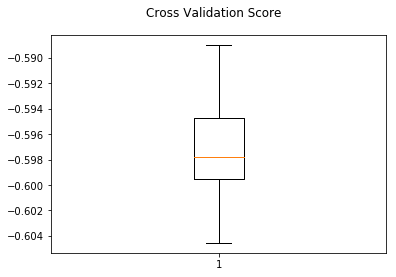

In [17]:
# reducing learning rate
xgb6 = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = 0.9,
    gamma = 0.4, 
    learning_rate = 0.01, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0.01,
    reg_lambda = 1,
    scale_pos_weight = 1, 
    seed = 0, 
    silent = True, 
    subsample = 0.9)

modelfit(xgb6, X_select, y, 'neg_log_loss' )

## Predictions

In [1]:
xgb = XGBClassifier(
    base_score = 0.5, 
    colsample_bylevel = 1, 
    colsample_bytree = 0.9,
    gamma = 0.4, 
    learning_rate = 0.01, 
    max_delta_step = 0, 
    max_depth = 3,
    min_child_weight = 3, 
    missing = None, 
    n_estimators = 100, 
    nthread = -1,
    objective = 'binary:logistic', 
    reg_alpha = 0.01,
    reg_lambda = 1,
    scale_pos_weight = 1, 
    seed = 0, 
    silent = True, 
    subsample = 0.9)





NameError: name 'XGBClassifier' is not defined